In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
import skimage.io as io
import skimage.transform as tr
import skimage.color
import dask.array as da
from glob import glob
from dask.array.image import imread

Using TensorFlow backend.
/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Reads the images from a path, iterating over all images
# - resizing them to a 1 channel grayscale image
# - saving all images in a numpy array, returns this array 
def read_imgs(path, size):
    imgs = []
    paths = glob(path)
    index = 0
    for p in paths:
        img = io.imread(p)
        img = tr.resize(img, size)
        imgs.append(img)
        index += 1
        if (index % 200 == 0):
            print(index)
    return np.array(imgs)

# Saves the data into a variable (x = input, y = masks / ground truth)
x = read_imgs('/home/dan/Desktop/Neural Network/data/dataset1_1/images/data/*.png', (224,224,1))
y = read_imgs('/home/dan/Desktop/Neural Network/data/dataset1_1/masks/data/*.png', (224,224,1))

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400


(224, 224)


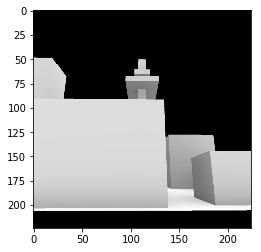

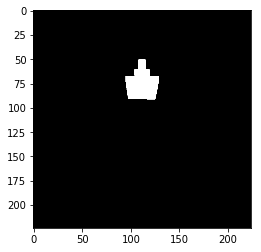

In [3]:
# Plots the images in jupyter notebook for comparison
i = 95
print(x[i, ..., 0].shape)
plt.imshow(x[i, ..., 0], cmap = 'gray')
plt.show()
plt.imshow(y[i, ..., 0], cmap='gray')
plt.show()

In [4]:
# Defining the loss function 
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1. - intersection)

def iou_loss(y_true, y_pred):
    return  -iou(y_true, y_pred)

#Altes Modell laden
from keras.models import load_model
model = load_model('modelsave2.h5', custom_objects={'iou_loss': iou_loss})

model.summary()

In [5]:
# Defining the model 
from unet import UNet
model = None
model = UNet((224,224,1), 1, 16, 4, 2.0)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [6]:
model.compile(optimizer=Adam(lr=0.0001), loss=iou_loss, metrics=['accuracy'])

In [7]:
train = 2043 # = 80% of all given data  
model.fit(x[:train], y[:train], batch_size=32, epochs=10,
         validation_data=(x[train:], y[train:]), shuffle=True)

Train on 2043 samples, validate on 412 samples
Epoch 1/10
2043/2043 [==============================] - 39s 19ms/step - loss: -0.0328 - acc: 0.8154 - val_loss: -0.1330 - val_acc: 0.9712
Epoch 2/10
2043/2043 [==============================] - 30s 15ms/step - loss: -0.2539 - acc: 0.9727 - val_loss: -0.3717 - val_acc: 0.9756
Epoch 3/10
2043/2043 [==============================] - 30s 15ms/step - loss: -0.3914 - acc: 0.9815 - val_loss: -0.4793 - val_acc: 0.9849
Epoch 4/10
2043/2043 [==============================] - 30s 14ms/step - loss: -0.4480 - acc: 0.9843 - val_loss: -0.5151 - val_acc: 0.9855
Epoch 5/10
2043/2043 [==============================] - 30s 15ms/step - loss: -0.5237 - acc: 0.9874 - val_loss: -0.5649 - val_acc: 0.9875
Epoch 6/10
2043/2043 [==============================] - 30s 15ms/step - loss: -0.5571 - acc: 0.9882 - val_loss: -0.5852 - val_acc: 0.9875
Epoch 7/10
2043/2043 [==============================] - 30s 15ms/step - loss: -0.5979 - acc: 0.9895 - val_loss: -0.6304 - val

In [8]:
# makes a prediction for the whole dataset
pred = model.predict(x, verbose=1)

2455/2455 [==============================] - 9s 4ms/step


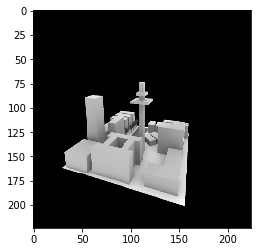

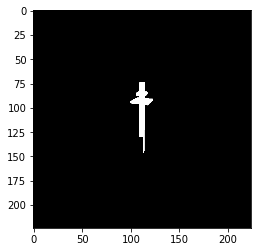

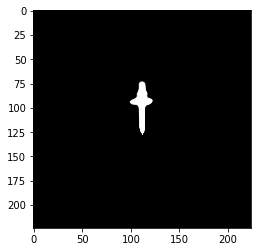

In [10]:
# Plots the prediction in jupyter notebook for comparison
i = 80
plt.imshow(x[i, ..., 0], cmap='gray')
plt.show()
plt.imshow(y[i, ..., 0], cmap='gray')
plt.show()
plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()

# Save the Model
Speichert
* die Architektur
* die Gewichte
* die Trainingskonfigurationen (loss, optimizer)
* State des Optimizers

In [14]:
model.save('ds1_1_small.h5')